In [146]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 

%matplotlib inline

In [127]:
df = pd.read_csv('../indeed_data_science_exercise/salary_data.csv', index_col=0)

In [128]:
# X not including target, companyId and all encoded columns
X = df.drop(['jobId', 'companyId', 'salary', 'jobType', 'degree', 'major', 
                    'industry'], axis=1)
# salary is the target
y = df['salary']

In [129]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [130]:
# Standardize X_train and X_test to transform yearsExperience and milesFromMetropolis to the same scale
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.fit_transform(X_test)

In [131]:
# Instantiate regressor and fit to train data
rf_reg = RandomForestRegressor()
rf_reg = rf_reg.fit(X_train_ss, y_train)

In [132]:
# Low standard deviation is a good indicator that the model generalizes well
print('Decision Tree Regressor Model R2 = {:.3} +/- {:.3} std'.format(cross_val_score(rf_reg, 
                                                                                X_test, y_test, 
                                                                                cv = 10).mean(),
                                                               (cross_val_score(rf_reg, X_test, y_test, 
                                                                                cv = 10).std())))

Decision Tree Regressor Model R2 = 0.715 +/- 0.00186 std


In [42]:
# Relative to the salaries between 0 and 300 (thousand) this is a desirable RMSE
y_pred = rf_reg.predict(X_test_ss)
rf_reg_rmse = mean_squared_error(y_test, y_pred)
rf_reg_rmse = np.sqrt(rf_reg_rmse)
print('Random Forest Regressor RMSE: %.4f' % rf_reg_rmse)

Random Forest Regressor RMSE: 20.7173


In [57]:
# RMSE of train data is expectidly much better than the test and this validates that it's not overfitting
y_pred_train = rf_reg.predict(X_train_ss)
rf_reg_rmse = mean_squared_error(y_train, y_pred_train)
rf_reg_rmse = np.sqrt(rf_reg_rmse)
print('Random Forest Regressor Train RMSE: %.4f' % rf_reg_rmse)

Random Forest Regressor Train RMSE: 8.6877


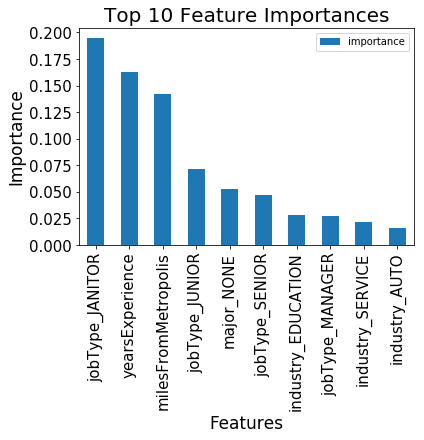

In [58]:
importances = pd.Series(rf_reg.feature_importances_.tolist())
features = pd.Series(X_train.columns.tolist())
fi = pd.concat([features, importances], axis=1, keys=['feature', 'importance']).set_index('feature')

fi = fi.sort_values(by='importance', ascending=False)

# Initial Analysis used all features, but looking at the feature importance from the Regression Tree, the only
#  featrues that are significant are yearsExperience and milesFromMetropolis
fi[:10].plot(kind='bar')
plt.title('Top 10 Feature Importances', fontsize = 20)
plt.xticks(fontsize=15)
plt.xlabel('Features', fontsize=17)
plt.yticks(fontsize=15)
plt.ylabel('Importance', fontsize=17)

plt.show()

In [78]:
# Top 5 feature importances
fi.head()

,importance
feature,
jobType_JANITOR,0.194736
yearsExperience,0.162541
milesFromMetropolis,0.142501
jobType_JUNIOR,0.071623
major_NONE,0.052684


In [79]:
# Bottom 5 feature importances
fi.tail()

,importance
feature,
companyId_COMP47,0.002170
companyId_COMP19,0.002168
companyId_COMP26,0.002161
jobType_CTO,0.001789
jobType_CFO,0.001776


In [95]:
# 1st Feature Importance
# Lower salary std relative to the worst feature importance jobType_CFO
df[ df['jobType']=='JANITOR' ]['salary'].std().round(1)

24.6

In [96]:
# Worst feature impotance
df[ df['jobType']=='CFO' ]['salary'].std().round(1)

33.1

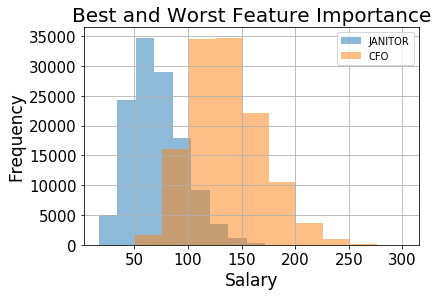

In [97]:
# Visual of the Best and Worst Distributions
plt.hist(df[ df['jobType']=='JANITOR' ]['salary'], alpha=0.5, label='JANITOR', )
plt.hist(df[ df['jobType']=='CFO' ]['salary'], alpha=0.5, label='CFO')
plt.legend(loc='best')
plt.grid(True)
plt.title('Best and Worst Feature Importance', fontsize=20)
plt.xticks(fontsize=15)
plt.xlabel('Salary', fontsize=17)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=17)
plt.show()

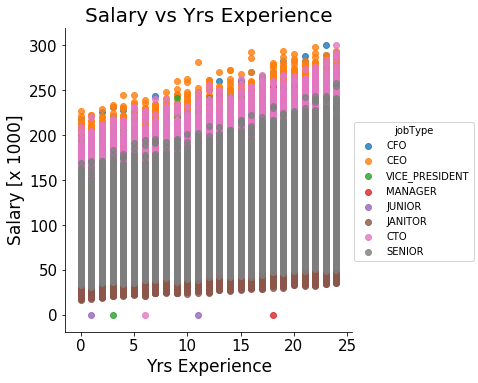

In [114]:
sns.lmplot(x='yearsExperience', y='salary', data=df, hue='jobType',fit_reg=False)
plt.Figure(figsize=(20,8))
plt.title('Salary vs Yrs Experience', fontsize=20)
plt.xlabel('Yrs Experience', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('Salary [x 1000]', fontsize=17)
plt.yticks(fontsize=15)
plt.show()

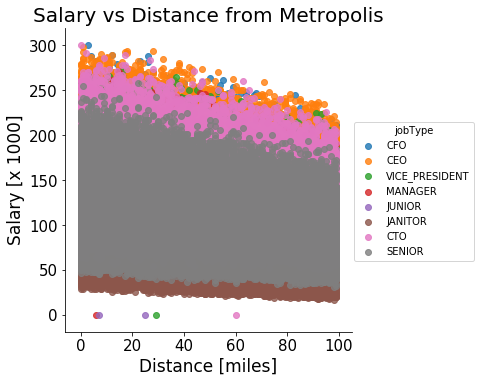

In [115]:
sns.lmplot(x='milesFromMetropolis', y='salary', data=df, hue='jobType', fit_reg=False)
plt.Figure(figsize=(20,8))
plt.title('Salary vs Distance from Metropolis', fontsize=20)
plt.xlabel('Distance [miles]', fontsize=17)
plt.xticks(fontsize=15)
plt.ylabel('Salary [x 1000]', fontsize=17)
plt.yticks(fontsize=15)
plt.show()

## Modeling with Only Years Experience and Distance from Metropolis Standardized

In [259]:
# defining the columns to be standardized
x_standardize = df.columns.tolist()[7:9]

# instantiate standard scaler and fit_transform the features
ss = StandardScaler()
X_standardized =ss.fit_transform(df[x_standardize])

# create a DataFrame of the array of standardized features
x_std = pd.DataFrame(X_standardized, columns=['yrsExperienc_ss', 'disFromMetropolis_ss'])

# join the new DataFrame with the original data
df_ss = pd.concat([df, x_std], axis=1)

In [260]:
df_ss[df_ss.columns[-2:]].dtypes

yrsExperienc_ss         float64
disFromMetropolis_ss    float64
dtype: object

In [261]:
# dropping all original features since they were either binarized or standardized
X = df_ss.copy().drop(['jobId', 'salary', 'companyId', 'jobType', 'degree', 'major',
                   'industry', 'yearsExperience', 'milesFromMetropolis'], 
                  axis=1)
# salary is the target
y = df_ss['salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [121]:
# instantiate and fit the regressor
rf_reg = RandomForestRegressor()
rf_reg = rf_reg.fit(X_train, y_train)

In [123]:
# Low standard deviation is a good indicator that the model generalizes well
s = cross_val_score(rf_reg, X_test, y_test, cv = 10)
print('Decision Tree Regressor Model R2 = {:.3} +/- {:.3} std'.format(s.mean(),s.std()))

Decision Tree Regressor Model R2 = 0.715 +/- 0.00186 std


In [124]:
# Relative to the salaries between 0 and 300 (thousand) this is a desirable RMSE for the Test data
y_pred = rf_reg.predict(X_test)
rf_reg_rmse = mean_squared_error(y_test, y_pred)
rf_reg_rmse = np.sqrt(rf_reg_rmse)
print('Random Forest Regressor RMSE: %.4f' % rf_reg_rmse)

Random Forest Regressor RMSE: 20.6910


In [125]:
# RMSE of train data is expectidly much better than the test and this validates that the model is not overfitting
y_pred_train = rf_reg.predict(X_train)
rf_reg_rmse = mean_squared_error(y_train, y_pred_train)
rf_reg_rmse = np.sqrt(rf_reg_rmse)
print('Random Forest Regressor Train RMSE: %.4f' % rf_reg_rmse)

Random Forest Regressor Train RMSE: 8.6760


# Other Models

#### Decision Tree Regressor

In [148]:
# Was expecting this model to yield better accuracy since they are prone to overfitting, need to go back and 
#  understand the cause of this
dt = DecisionTreeRegressor()
s = cross_val_score(dt, X_test, y_test, cv=10, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Decision Tree Regressor R2", s.mean().round(3), s.std().round(3)))

Decision Tree Regressor R2 Score:	0.529 ± 0.002


#### Random Forest Regressor

In [143]:
# Random Forest was analyzed in above code, but shown for sake of comparison
dt = RandomForestRegressor()
s = cross_val_score(dt, X_test, y_test, cv=10, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest Regressor R2", s.mean().round(3), s.std().round(3)))

Random Forest Regressor R2 Score:	0.716 ± 0.002


#### Bagging Regressor

In [144]:
# Another ensemble method like Random Forest yields the same results as the Random Forest --> reduced variance equally
dt = BaggingRegressor()
s = cross_val_score(dt, X_test, y_test, cv=10, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Bagging Regressor R2", s.mean().round(3), s.std().round(3)))

Bagging Regressor R2 Score:	0.716 ± 0.002


#### Extra Trees Regressor

In [145]:
# Was expecting slighly lower results than the Random Forest, but just shows the effectiveness of reducing variance
dt = ExtraTreesRegressor()
s = cross_val_score(dt, X_test, y_test, cv=10, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Extra Trees Regressor R2", s.mean().round(3), s.std().round(3)))

Extra Trees Regressor R2 Score:	0.698 ± 0.002


## Results

In [152]:
# verifying location
!ls ../indeed_data_science_exercise/test_features_2013-03-07.csv

../indeed_data_science_exercise/test_features_2013-03-07.csv


In [156]:
# importing the test data
test = pd.read_csv('../indeed_data_science_exercise/test_features_2013-03-07.csv')

In [239]:
# validating that the train data is the same lenght as the test data
print(len(test))
print(len(df))

1000000
1000000


In [157]:
# only features with no salary info
test.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


#### pre-process the test data

In [164]:
# Binary encoding the categorical features
encoding = test.columns.tolist()[1:6]
encoded = pd.get_dummies(test[encoding])

In [170]:
# Standardizing years Experience and milesFromMetropolis so they don't have significanlty more weight than other
#  features
x_to_std = test.columns.tolist()[6:]
ss = StandardScaler()
x_std =ss.fit_transform(test[x_to_std])
x_std = pd.DataFrame(X_standardized, columns=['yrsExperienc_ss', 'disFromMetropolis_ss'])

In [171]:
# Pre-processed test features
test = pd.concat([test, encoded, x_std], axis=1)

In [176]:
# showing column names to reference for what to drop in next code block
test.columns[:8]

Index(['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry',
       'yearsExperience', 'milesFromMetropolis'],
      dtype='object')

In [178]:
# Creating the X variable to test on the model
X_test = test.copy().drop(['jobId', 'companyId', 'jobType', 'degree', 'major',
                   'industry', 'yearsExperience', 'milesFromMetropolis'], 
                  axis=1)

In [263]:
# instantiate the regressor and fit on the entire original data
rf_reg = RandomForestRegressor( )
rf_reg = rf_reg.fit(df_ss[df_ss.columns[9:]], df_ss['salary'])
y_pred = rf_reg.predict(X_test)

In [264]:
# creae a DataFrame of the predicted values
y_pred = pd.Series(y_pred)

In [265]:
# join the salary predictions with the test data and call in test_salaries
test_sal = pd.concat([test,y_pred], axis=1)

# predicted salaries column was labeled 0 so changed to 'salary_pred'
test_sal.rename(columns={0:'salary_pred'}, inplace=True)

In [266]:
# looking at train data Job ID's
df[['jobId','salary']].head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [267]:
# looking at test_sal to compare to the train data Job ID's
test_sal[['jobId','salary_pred']].head()

,jobId,salary_pred
0,JOB1362685407687,153.9
1,JOB1362685407688,58.1
2,JOB1362685407689,178.7
3,JOB1362685407690,94.1
4,JOB1362685407691,135.6


In [268]:
# Job ID's do not match between test_salaries and the original data.  Will join on index, but not sure if it's
#  a good side by side comparison of actual vs predicted
df[['jobId','salary']][ df['jobId']=='JOB1362685407687']

,jobId,salary


In [269]:
# Creating test_salaries DataFrame to create a CSV with
test_salaries = test_sal[['jobId','salary_pred']]

In [270]:
# making sure the source location is correct before exporting the data frame as a csv
!ls ../indeed_data_science_exercise/

Indeed_DS_Exercise.zip        test_salaries.csv
salary_data.csv               train_features_2013-03-07.csv
salry_data_ne.csv             train_salaries_2013-03-07.csv
test_features_2013-03-07.csv


In [271]:
# exporting the data frame as a csv
test_salaries.to_csv('../indeed_data_science_exercise/test_salaries.csv')